In [ ]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
from importlib import reload
import setGPU

In [ ]:
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)

In [ ]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = batch_size*5000
nodes_n, feat_sz, particles_bg, A_bg, A_tilde_bg = prepr.prepare_data(filename_bg,train_set_size,0,train_set_size+1)
#BG test
_,_, particles_bg_test, A_bg_test, A_tilde_bg_test = prepr.prepare_data(filename_bg,5000,train_set_size+1,train_set_size+5000)

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
batch_size = 128
valid_set_size = batch_size*1000
_,_, particles_bg_valid, A_bg_valid, A_tilde_bg_valid = prepr.prepare_data(filename_bg,valid_set_size,0,valid_set_size+1)


In [46]:
filename_bg_valid

'/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_parts/qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband_000.h5'

In [30]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig, A_sig, A_tilde_sig = prepr.prepare_data(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 100
Number of features = 3


In [23]:
print(particles_bg.shape, A_tilde_bg.shape, A_bg.shape)

(6400, 100, 3) (6400, 100, 100) (6400, 100, 100)


# Plot features

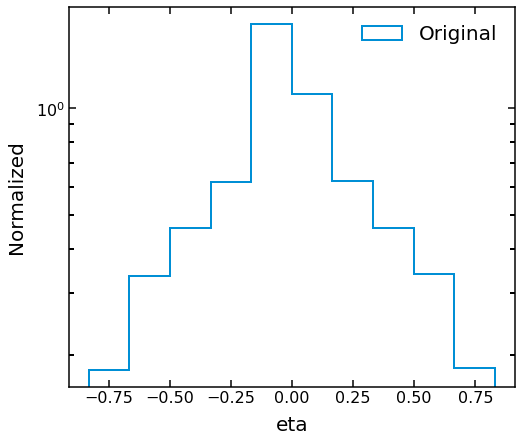

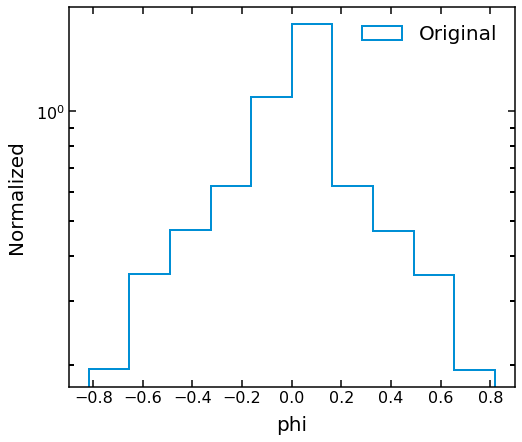

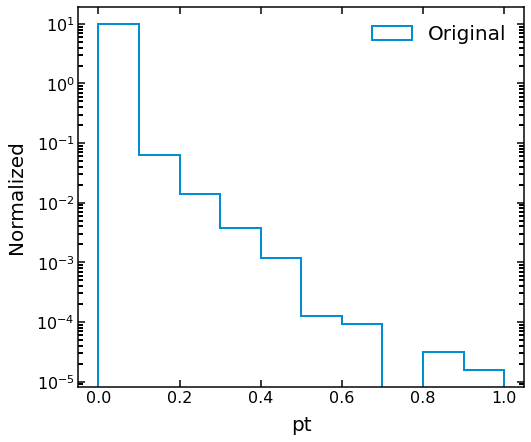

In [24]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=10, label='Original', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()

# Autoencoder

In [7]:
gnn = models.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True) 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution (GraphConvolu (None, 100, 6)       42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_1 (GraphConvo (None, 100, 8)       104         graph_convolution[0][0

In [11]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
gnn.fit((particles_bg, A_tilde_bg), A_bg, epochs=50, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/50
38/38 [==============================] - 5s 120ms/step - val_loss: 0.4240
Epoch 2/50
38/38 [==============================] - 4s 116ms/step - val_loss: 0.4240
Epoch 3/50
38/38 [==============================] - 4s 113ms/step - val_loss: 0.4240
Epoch 4/50
38/38 [==============================] - 4s 111ms/step - val_loss: 0.4240
Epoch 5/50
38/38 [==============================] - 4s 116ms/step - val_loss: 0.4240
Epoch 6/50
38/38 [==============================] - ETA: 0s
Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
38/38 [==============================] - 4s 107ms/step - val_loss: 0.4240
Epoch 7/50
38/38 [==============================] - 4s 108ms/step - val_loss: 0.4240
Epoch 8/50
38/38 [==============================] - 4s 113ms/step - val_loss: 0.4240
Epoch 00008: early stopping


## Predict BG and Sig

In [12]:
z_sig, A_pred_sig = gnn((particles_sig, A_tilde_sig))
z_bg_test, A_pred_bg_test = gnn((particles_bg_test, A_tilde_bg_test))
loss_signal_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gnn = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()

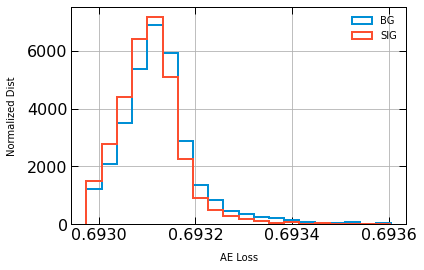

In [13]:
max_score = np.quantile(loss_signal_gnn,0.999)#,np.max(loss_bg_dist))
min_score = np.quantile(loss_bg_gnn,0.05)#,np.max(loss_bg_dist))
bins = 20
# plot BG
plt.figure()
plt.hist(loss_bg_gnn, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
plt.hist(loss_signal_gnn, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=2)
#plt.semilogy()
plt.xlabel("AE Loss")
plt.ylabel("Normalized Dist")
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# GVAE

In [14]:
gvae = models.GraphVariationalAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh)
gvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), run_eagerly=True) 

In [15]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)] 
gvae.fit((particles_bg, A_tilde_bg), A_bg, epochs=30, batch_size=128, validation_data = ((particles_bg_valid, A_tilde_bg_valid),A_bg_valid), callbacks=callbacks) 

Epoch 1/30
50/50 [==============================] - 4s 84ms/step - loss: 1.9692 - loss_reco: 0.7550 - loss_latent: 1.2142 - val_loss: 1.7923 - val_loss_reco: 0.6916 - val_loss_latent: 1.1007
Epoch 2/30
50/50 [==============================] - 5s 97ms/step - loss: 1.6587 - loss_reco: 0.6679 - loss_latent: 0.9908 - val_loss: 1.5036 - val_loss_reco: 0.6156 - val_loss_latent: 0.8880
Epoch 3/30
50/50 [==============================] - 5s 100ms/step - loss: 1.3976 - loss_reco: 0.6033 - loss_latent: 0.7943 - val_loss: 1.2698 - val_loss_reco: 0.5622 - val_loss_latent: 0.7076
Epoch 4/30
50/50 [==============================] - 5s 99ms/step - loss: 1.1824 - loss_reco: 0.5499 - loss_latent: 0.6325 - val_loss: 1.0781 - val_loss_reco: 0.5137 - val_loss_latent: 0.5644
Epoch 5/30
50/50 [==============================] - 5s 98ms/step - loss: 1.0151 - loss_reco: 0.5081 - loss_latent: 0.5069 - val_loss: 0.9330 - val_loss_reco: 0.4777 - val_loss_latent: 0.4553
Epoch 6/30
50/50 [==========================

In [16]:
z_sig, z_mean_sig, z_log_var_sig, A_pred_sig = gvae((particles_sig, A_tilde_sig))
z_bg_test,z_mean_bg_test, z_log_var_bg_test, A_pred_bg_test = gvae((particles_bg_test, A_tilde_bg_test))
loss_signal_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_sig, A_pred_sig), axis=(1,2)).numpy() #predicted adjecny, but not set to 0/1 yet
loss_bg_gvae = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_bg_test, A_pred_bg_test), axis=(1,2)).numpy()


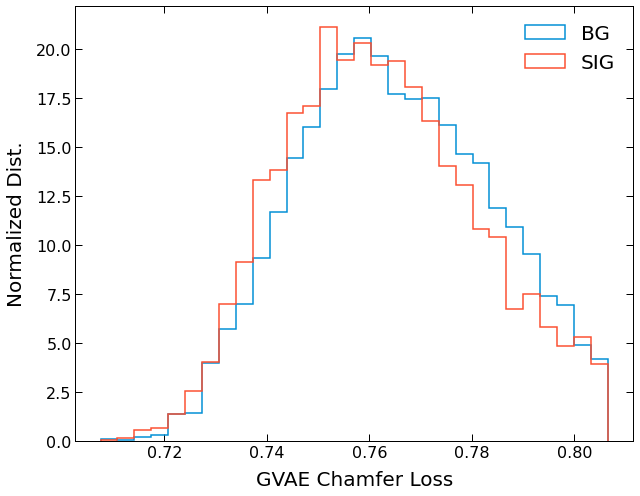

In [17]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal_gvae,0.95)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg_gvae)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg_gvae, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal_gvae, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("GVAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

# GCN VAE

In [31]:
def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)



In [32]:
import models.losses as losses
reload(losses)
import models.models as models
reload(models)
import utils.preprocessing as prepr
reload(prepr)


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [33]:
gcnvae = models.GCNVariationalAutoEncoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.tanh,latent_dim=50,kl_warmup_time=10)
gcnvae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

100
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 100, 3)]     0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 100, 100)]   0                                            
__________________________________________________________________________________________________
graph_convolution_6 (GraphConvo (None, 100, 6)       42          encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_7 (GraphConvo (None, 100, 2)       26          graph_convolution_

In [34]:
#tf.keras.utils.plot_model(gcnvae, show_shapes=True)

In [35]:
custom_callback = models.KLWarmupCallback()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, verbose=2),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2),custom_callback] 
gcnvae.fit(particles_bg, A_tilde_bg, epochs=50, batch_size=128, 
           validation_data = ((particles_bg_valid, A_tilde_bg_valid)), callbacks=callbacks) 


Epoch 1/50
5000/5000 [==============================] - 200s 40ms/step - loss: 0.0188 - loss_reco: 0.0188 - loss_latent: 4.0640 - beta_kl_warmup: 0.0000e+00 - val_loss: 0.0126 - val_loss_reco: 0.0126 - val_loss_latent: 3.4063 - ETA: 1:05 - loss: 0.0220 - loss_reco: 0.0220 - loss_latent: 3.9050 - beta_kl_warmup: 0.0000e+ - ETA: 1:05 - loss: 0.02
Epoch 2/50
5000/5000 [==============================] - 191s 38ms/step - loss: 0.0171 - loss_reco: 0.0160 - loss_latent: 0.0011 - beta_kl_warmup: 0.1000 - val_loss: 0.0141 - val_loss_reco: 0.0140 - val_loss_latent: 2.4171e-05
Epoch 3/50
5000/5000 [==============================] - 192s 38ms/step - loss: 0.0133 - loss_reco: 0.0133 - loss_latent: 5.2471e-06 - beta_kl_warmup: 0.2000 - val_loss: 0.0129 - val_loss_reco: 0.0129 - val_loss_latent: 1.4758e-06
Epoch 4/50
5000/5000 [==============================] - 193s 39ms/step - loss: 0.0125 - loss_reco: 0.0125 - loss_latent: 5.4855e-07 - beta_kl_warmup: 0.3000 - val_loss: 0.0125 - val_loss_reco: 0.01

5000/5000 [==============================] - 207s 41ms/step - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.5043e-07 - beta_kl_warmup: 1.0000 - val_loss: 0.0122 - val_loss_reco: 0.0122 - val_loss_latent: 7.6890e-08_kl_warm - ETA: 2:44 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.5171e-07 - be - ETA: 2:43 - loss: 0.0 - ETA: 2:40 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 3.3 - ETA: 2:36 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.9812e-07 - beta_kl_warmup:  - ETA: 2:36 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.9630e-07 - beta_kl_warmup: 1. - ETA: 2:36 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.9507e-07 - beta_kl_warmup - ETA: 2:35 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.9267e-07 - beta_kl_warmup - ETA: 2:35 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.9031e-07 - beta_kl_warmup: 1.00 - ETA: 2:35 - loss: 0.0118 - loss_reco: 0.0118 - loss_latent: 2.8972e-07 - beta_kl_warmup: 1.00 - ETA: 2:35 - loss: 0.0118 - loss_reco: 0.0118 

KeyboardInterrupt: 

In [36]:

def threeD_loss_manual(inputs, outputs):
    distances = np.sum(np.subtract(inputs[:,:,np.newaxis,:],outputs[:,np.newaxis,:,:])**2, axis=-1)
    min_dist_to_inputs = np.min(distances,axis=1)
    min_dist_to_outputs = np.min(distances,axis=2)
    return np.sum(min_dist_to_inputs,axis=1) + np.sum(min_dist_to_outputs,axis=1)




In [ ]:
loaded_1 = tf.keras.models.load_model(
    "output_model_saved_003", custom_objects={"GCNVariationalAutoEncoder": models.GCNVariationalAutoEncoder}
)


In [37]:
#Predict

#model = loaded_1
model = gcnvae

features_out_bg_test, z_bg_test, z_mean_bg_test, z_log_var_bg_test = model((particles_bg_test, A_tilde_bg_test))
features_out_bg_test = features_out_bg_test.numpy().astype('float32')
loss_bg = threeD_loss_manual(particles_bg_test.astype('float32'),features_out_bg_test)

features_out_sig, z_sig, z_mean_sig, z_log_var_sig = model((particles_sig, A_tilde_sig))
features_out_sig = features_out_sig.numpy().astype('float32')
loss_signal = threeD_loss_manual(particles_sig.astype('float32'),features_out_sig)

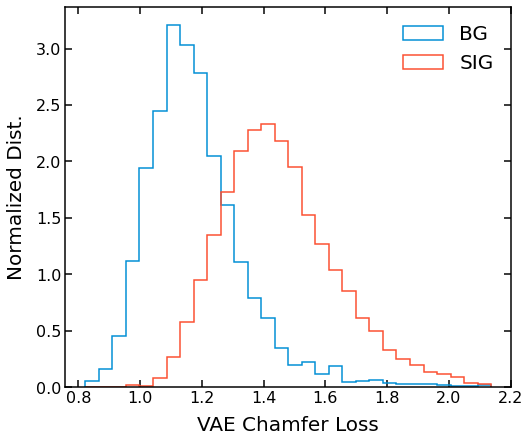

In [38]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_signal,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_signal, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
plt.show()

In [17]:
print(np.quantile(loss_bg,0.8),np.quantile(loss_signal,0.8))

46.138908386230476 56.10126342773438


In [39]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../vande/')))
sys.path.append(os.path.abspath(os.path.join('../pofah/')))
sys.path.append(os.path.abspath(os.path.join('../sarewt/')))

In [40]:
import vande.analysis.analysis_roc as ar
reload(ar)

<module 'vande.analysis.analysis_roc' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py'>

In [41]:
#neg_class_losses = [loss_bg.tolist(),loss_bg_gnn.tolist(),loss_bg_gvae.tolist()]
#pos_class_losses = [loss_signal.tolist(),loss_signal_gnn.tolist(),loss_signal_gvae.tolist()]
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_signal.tolist()]

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


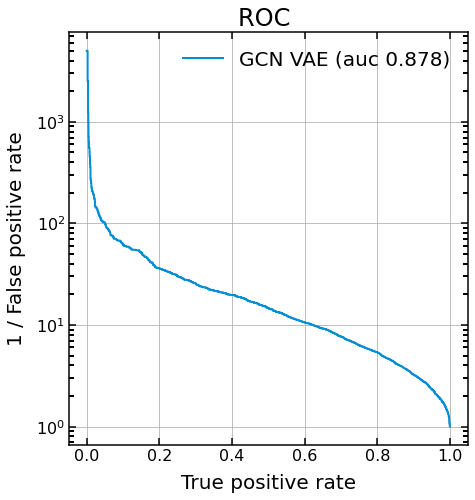

[0.8779448599999999]

In [42]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
#ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE','GAE','GVAE'], title='ROC ',
#            plot_name='ROC_text', fig_dir='figs/',log_x=False )
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['GCN VAE'], title='ROC ',
            plot_name='ROC_gcnvae', fig_dir='figs/',log_x=False )



# Plot features 

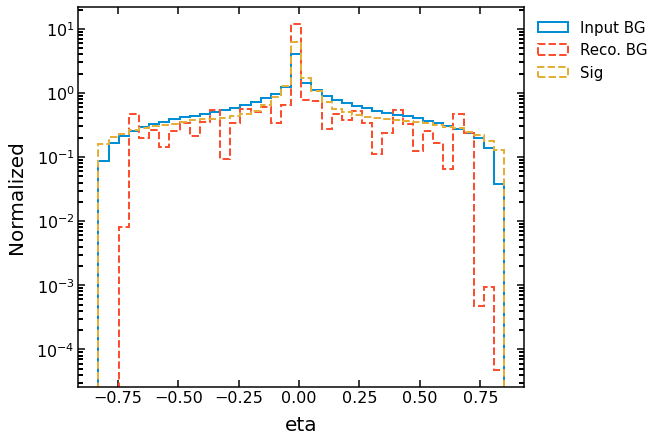

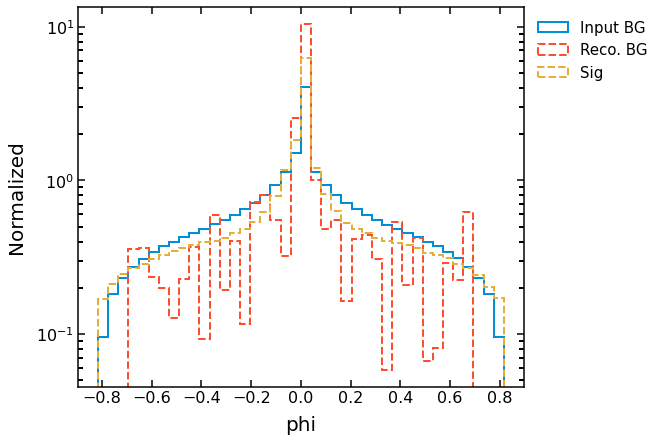

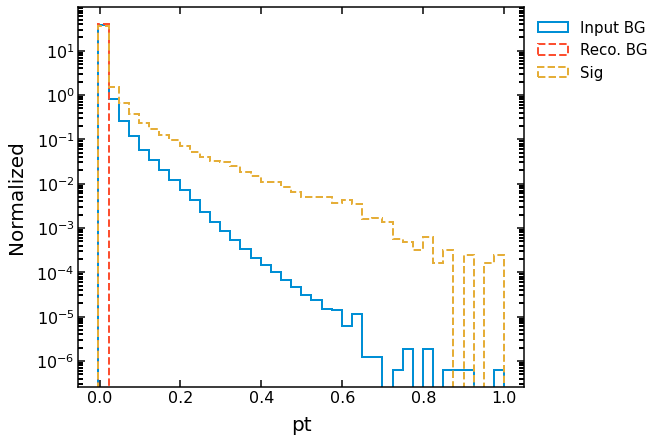

In [45]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(features_out_bg_test[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(features_out_bg_test[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(features_out_bg_test[:,:,i].flatten(), bins=bins,label='Reco. BG',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.hist(particles_sig[:,:,i].flatten(), bins=bins,label='Sig ',linestyle='--', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    plt.show()